<a href="https://colab.research.google.com/github/MayJarung/IMAGE-PROCESSING/blob/main/Lab6_Param1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**6.1 Load Base Model and Add New Layers**

In [21]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

import tensorflow as tf

In [22]:
#Load base model
base_model=MobileNet(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

    สร้างโมเดล MobileNet ที่ถูกฝึกสอนล่วงหน้าด้วย imagenet และใช้ในงานที่เกี่ยวข้องกับการประมวลผลรูปภาพโดยรูปภาพนำเข้าจะต้องมีขนาด (224, 224, 3)

In [23]:
# Add new layers
x = base_model.output

# Add GlobalAveragePooling2D layer
x = GlobalAveragePooling2D()(x)

# Add Dense layers
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# Add the final output layer with Softmax activation for 3 classes
preds = Dense(3, activation='softmax')(x)

    ปรับจำนวน Node ใน แต่ละ Dense layer

**Model.summary() : ตัวอย่าง layer ต้น และ layer ท้ายที่ต่อเพิ่ม**

In [24]:
# Assign transfer base model + new layers to model
model = Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [25]:
# Freeze the first 86 layers (non-trainable)
for layer in model.layers[:86]:
    layer.trainable = False

# Unfreeze the layers from 87 and beyond (trainable)
for layer in model.layers[86:]:
    layer.trainable = True

    ปรับ Layer freeze และ unfreeze เข้าไปใน base model CNN layers

In [26]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name)

0 input_2
1 conv1
2 conv1_bn
3 conv1_relu
4 conv_dw_1
5 conv_dw_1_bn
6 conv_dw_1_relu
7 conv_pw_1
8 conv_pw_1_bn
9 conv_pw_1_relu
10 conv_pad_2
11 conv_dw_2
12 conv_dw_2_bn
13 conv_dw_2_relu
14 conv_pw_2
15 conv_pw_2_bn
16 conv_pw_2_relu
17 conv_dw_3
18 conv_dw_3_bn
19 conv_dw_3_relu
20 conv_pw_3
21 conv_pw_3_bn
22 conv_pw_3_relu
23 conv_pad_4
24 conv_dw_4
25 conv_dw_4_bn
26 conv_dw_4_relu
27 conv_pw_4
28 conv_pw_4_bn
29 conv_pw_4_relu
30 conv_dw_5
31 conv_dw_5_bn
32 conv_dw_5_relu
33 conv_pw_5
34 conv_pw_5_bn
35 conv_pw_5_relu
36 conv_pad_6
37 conv_dw_6
38 conv_dw_6_bn
39 conv_dw_6_relu
40 conv_pw_6
41 conv_pw_6_bn
42 conv_pw_6_relu
43 conv_dw_7
44 conv_dw_7_bn
45 conv_dw_7_relu
46 conv_pw_7
47 conv_pw_7_bn
48 conv_pw_7_relu
49 conv_dw_8
50 conv_dw_8_bn
51 conv_dw_8_relu
52 conv_pw_8
53 conv_pw_8_bn
54 conv_pw_8_relu
55 conv_dw_9
56 conv_dw_9_bn
57 conv_dw_9_relu
58 conv_pw_9
59 conv_pw_9_bn
60 conv_pw_9_relu
61 conv_dw_10
62 conv_dw_10_bn
63 conv_dw_10_relu
64 conv_pw_10
65 conv_pw_1

**6.2 Model Training and Validation**

In [27]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [28]:
import zipfile

zip_file_path = '/content/drive/MyDrive/ImageProcessing/Lab6/Ship.zip'
extract_path = '/content/drive/MyDrive/ImageProcessing/Lab6/Dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [29]:
batch_size = 32
seed_value = 42

In [30]:
datagen = ImageDataGenerator(rotation_range=40,
                             zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             horizontal_flip=True,
                             preprocessing_function=preprocess_input,
                             fill_mode="nearest")

In [31]:
train_generator = datagen.flow_from_directory('/content/drive/MyDrive/ImageProcessing/Lab6/Dataset/Train/../.',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              seed=seed_value,
                                              shuffle=True)

Found 181 images belonging to 3 classes.


In [32]:
val_generator = datagen.flow_from_directory('/content/drive/MyDrive/ImageProcessing/Lab6/Dataset/Validate/../.',
                                            target_size=(224, 224),
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            seed=seed_value,
                                            shuffle=True)

Found 181 images belonging to 3 classes.


In [33]:
# สร้างฟังก์ชันสำหรับแสดงรูปภาพเป็นตาราง 4x4
def plot_images(generator, num_images=16):
    # สร้าง subplot 4x4
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    # ดึงรูปภาพจาก generator
    for i in range(num_images):
        # ดึงรูปภาพ
        batch = generator.next()
        img = batch[0][0]

        # แปลงค่าความเข้มเป็นช่วง [0, 1]
        img = img / 2.0 + 0.5

        # แสดงรูปภาพ
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

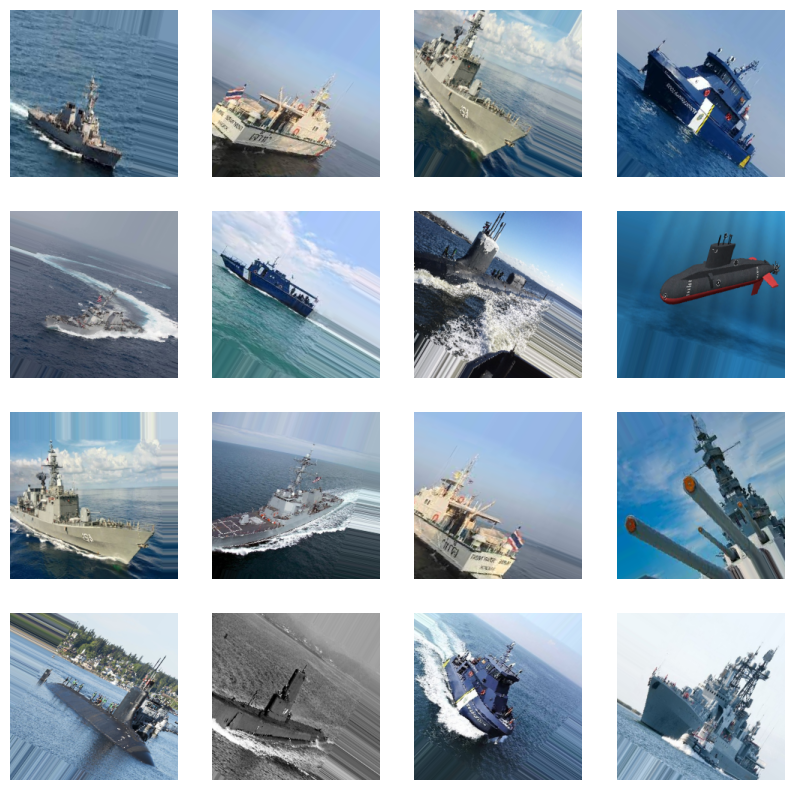

In [34]:
# แสดงรูปภาพจาก train_generator
plot_images(train_generator, num_images=16)

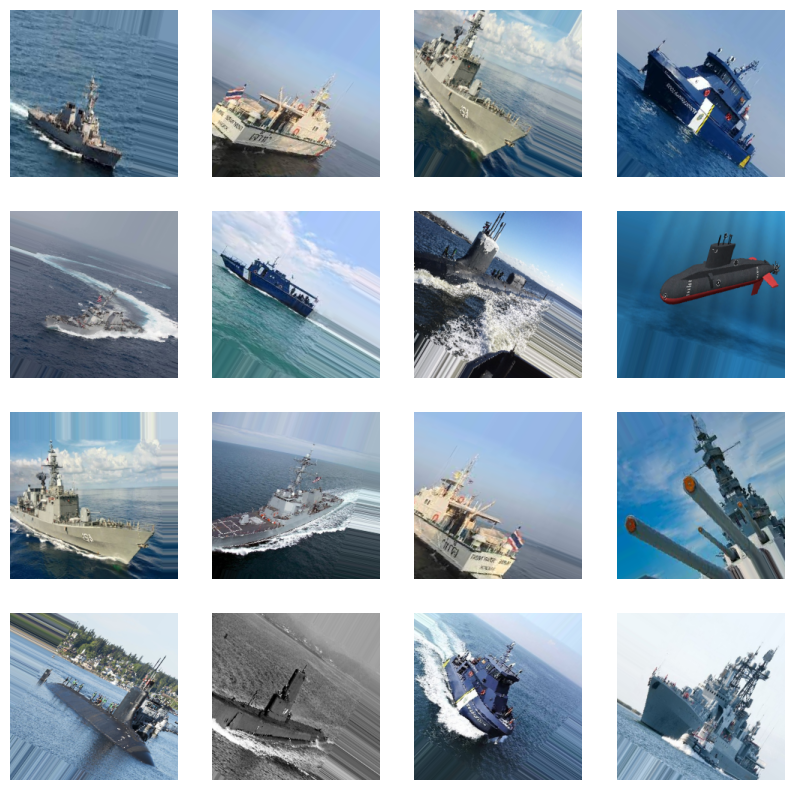

In [35]:
# แสดงรูปภาพจาก val_generator
plot_images(val_generator, num_images=16)

In [36]:
opts = Adam(learning_rate = 0.0001, use_ema=True)
model.compile(loss='categorical_crossentropy',optimizer=opts,metrics=['accuracy'])

In [37]:
# Define training Generator Parameter

step_size_train=train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size
# check step_size_Train = step_size_val -> if not, adjust batch_size to make it equal

if step_size_train == step_size_val:
    print("step_size_train is equal to step_size_val.")
    print(f"Number of steps per epoch: {step_size_train}")
else:
    print("step_size_train is not equal to step_size_val.")
    print(f"Number of steps per epoch (train): {step_size_train}")
    print(f"Number of steps per epoch (validation): {step_size_val}")

step_size_train is equal to step_size_val.
Number of steps per epoch: 5


In [38]:
EP = 10

In [39]:
history=model.fit_generator(generator=train_generator,
                            steps_per_epoch=step_size_train,
                            validation_data = val_generator,
                            validation_steps = step_size_val,
                            epochs=EP,verbose = 1)

<ipython-input-39-6fa91c5968ed>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator=train_generator,


Epoch 1/10
5/5 [==============================] - 26s 5s/step - loss: 0.9283 - accuracy: 0.5168 - val_loss: 1.0393 - val_accuracy: 0.5188
Epoch 2/10
5/5 [==============================] - 21s 5s/step - loss: 0.9435 - accuracy: 0.5312 - val_loss: 0.8942 - val_accuracy: 0.4625
Epoch 3/10
5/5 [==============================] - 19s 4s/step - loss: 0.9168 - accuracy: 0.4497 - val_loss: 0.8771 - val_accuracy: 0.5437
Epoch 4/10
5/5 [==============================] - 31s 7s/step - loss: 0.8387 - accuracy: 0.5235 - val_loss: 0.8310 - val_accuracy: 0.5312
Epoch 5/10
5/5 [==============================] - 54s 13s/step - loss: 0.8057 - accuracy: 0.5570 - val_loss: 0.8085 - val_accuracy: 0.5688
Epoch 6/10
5/5 [==============================] - 30s 7s/step - loss: 0.8317 - accuracy: 0.5503 - val_loss: 0.7736 - val_accuracy: 0.5625
Epoch 7/10
5/5 [==============================] - 29s 7s/step - loss: 0.8302 - accuracy: 0.5168 - val_loss: 0.7962 - val_accuracy: 0.6062
Epoch 8/10
5/5 [=================

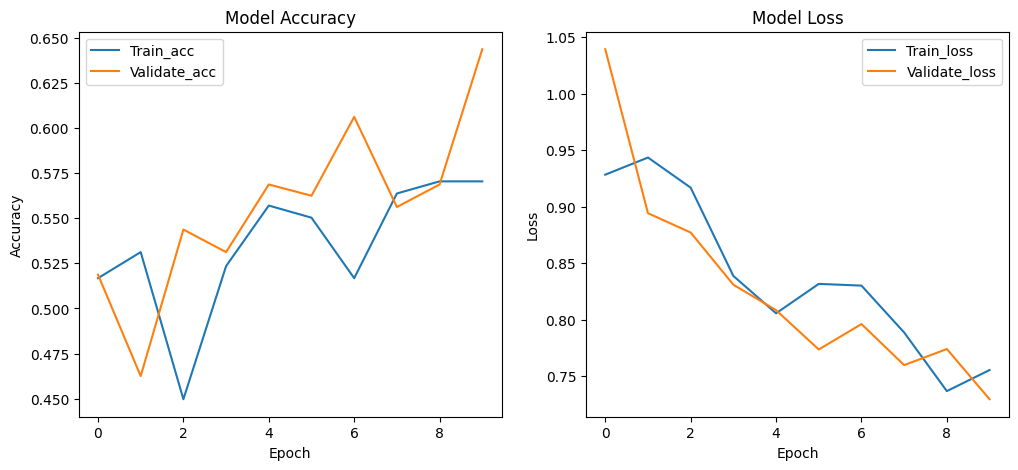

In [44]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax1.plot(history.epoch, history.history["accuracy"], label="Train_acc")
ax1.plot(history.epoch, history.history["val_accuracy"], label="Validate_acc")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()

# Plot Loss
ax2.plot(history.epoch, history.history['loss'], label="Train_loss")
ax2.plot(history.epoch, history.history['val_loss'], label="Validate_loss")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()

plt.show()

**6.3 Model Testing and Performance Visualize**

In [46]:
# Initial test generator
test_generator = datagen.flow_from_directory('/content/drive/MyDrive/ImageProcessing/Lab6/Dataset/Test/../.',
                                             class_mode="categorical",
                                             target_size=(224, 224), color_mode="rgb",
                                             shuffle=False,
                                             batch_size=1)

Found 181 images belonging to 3 classes.


In [48]:
#Get class id for y_real_class
y_true = test_generator.classes

In [49]:
#predict images according to test_generator # number of real class
preds = model.predict_generator(test_generator)
print(preds.shape)
print(preds)

<ipython-input-49-1585526648b4>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


(181, 3)
[[0.35646212 0.3962908  0.24724708]
 [0.15365179 0.41523585 0.43111238]
 [0.17261857 0.522163   0.3052185 ]
 [0.20727786 0.51062024 0.28210187]
 [0.1723527  0.5181084  0.3095389 ]
 [0.2322727  0.4545729  0.3131544 ]
 [0.16936491 0.5843939  0.24624123]
 [0.20842434 0.47146463 0.320111  ]
 [0.19381446 0.4274733  0.37871218]
 [0.2752491  0.509114   0.21563685]
 [0.30746582 0.43117726 0.26135692]
 [0.16542809 0.48963833 0.34493357]
 [0.22410786 0.39694288 0.3789492 ]
 [0.1178453  0.45766857 0.4244861 ]
 [0.22737625 0.41953784 0.3530859 ]
 [0.13183783 0.63012046 0.23804177]
 [0.07897621 0.5087727  0.4122511 ]
 [0.11431672 0.4425119  0.44317135]
 [0.15187621 0.48223656 0.36588725]
 [0.19129193 0.36877134 0.43993673]
 [0.14069115 0.44155422 0.4177547 ]
 [0.14611739 0.5795217  0.27436092]
 [0.12062885 0.5962746  0.28309658]
 [0.20779097 0.46278247 0.3294266 ]
 [0.18428825 0.46350306 0.35220867]
 [0.15139328 0.47492555 0.37368116]
 [0.11362583 0.49999994 0.3863742 ]
 [0.1619425  0.4443

In [50]:
y_pred = np.argmax(preds,axis=1)
print(test_generator.classes)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1]


In [54]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 0 14  1]
 [ 0 92  5]
 [ 0 64  5]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.54      0.95      0.69        97
           2       0.45      0.07      0.12        69

    accuracy                           0.54       181
   macro avg       0.33      0.34      0.27       181
weighted avg       0.46      0.54      0.42       181



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Q1: Number of training , validation , test images ?**

    จำนวนข้อมูลในแต่ละ class มีปริมาณใกล้เคียงกันหรือไม่
    Ans. ใกล้เคียงกันกัน

    จำนวนข้อมูลทั้งหมด มีมากพอจะให้เข้าใจความแตกต่างของ class หรือไม่
    Ans. มีมากพอ

**Q2: Which pre-train layers are set trainable?**

    ปรับแล้ว มีผลต่อ accuracy มากน้อย อย่างไร
    Ans. ไม่แน่ใจเหมือนกันค่ะว่ามีผลมากน้อยแค่ไหน เพราะที่ทดลอง set trainable ที่ layer 87 เป็นต้นไป กับ set trainable ที่ layer 41 เป็นต้นไปนั้น ใช้ parameter ต่างกันในการเทรน แต่เดี๋ยวไปหาคำตอบเพิ่มเติมค่ะ แง้

**Q3: What is the maximum accuracies of train , validation , test(predict) ?**

    กรณีที่ใช้ Paramiter ชุดที่ 1 (10 epochs)
    Maximum Accuracy of train = 0.5705
    Maximum Accuracy of validation = 0.6438
    Maximum Accuracy of test(predict) = 0.54

    กรณีที่ใช้ Paramiter ชุดที่ 2 (100 epochs)
    Maximum Accuracy of train = 0.7344
    Maximum Accuracy of validation = 0.7266
    Maximum Accuracy of test(predict) = 0.70

**Q4: เมื่อ training ผ่านไปในแต่ละ Epoch**

    Training accuracy เป็นอย่างไร เมื่อเทียบกับ Validation accuracy
    Ans. Training accuracy ส่วนใหญ่จะน้อยกว่า Validation accuracy

    Training Loss เป็นอย่างไร เมื่อเทียบกับ Validation loss
    Ans. Training Loss ส่วนใหย่จะมากกว่า Validation loss

    เพิ่มจำนวน Epoch แล้ว มีผลอย่างไรกับค่า accuracy, loss
    Ans. เมื่อเทรนด้วย Epoch เยอะขึ้น ค่า accuracy ก็จะมากขึ้น ส่วนค่า loss จะลดลง

**Q5: จาก confusion matrix ดูอย่างไรว่า class ไหน ทำนายผิด และ ที่ทำนายผิด ทำนายไปเป็น class ใด**
    
    กรณีที่ใช้ Parameter 1 ในการทดลอง   

            y_predict
     y_true [[ 0 14  1]
             [ 0 92  5]
             [ 0 64  5]]

    Class 0 ทำนายผิด มีจำนวน 14 รายการ ที่ทำนายว่าเป็น Class 1 และมีจำนวน 1 รายการ ที่ทำนายว่าเป็น Class 2
    Class 1 ทำนายผิด มีจำนวน  5 รายการ ที่ทำนายว่าเป็น Class 2
    Class 2 ทำนายผิด มีจำนวน  64 รายการ ที่ทำนายว่าเป็น Class 1

    กรณีที่ใช้ Parameter 2 ในการทดลอง   

            y_predict
     y_true [[14  1  0]
             [ 0 64 33]
             [ 0 20 49]]

    Class 0 ทำนายผิด มีจำนวน 1 รายการ และทำนายว่าเป็นคลาส Class 1
    Class 1 ทำนายผิด มีจำนวน 33 รายการ และทำนายว่าเป็นคลาส Class 2
    Class 2 ทำนายผิด มีจำนวน 20 รายการ และทำนายว่าเป็นคลาส Class 1
         

